<a href="https://colab.research.google.com/github/godblessourdeadkotatsu/lecture-notes-2024-25/blob/main/IDM/Lab_3_Anomaly_Detection_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly Detection Part 1 (Synthetic Examples)

Anomaly detection tries to identify outliers in the data. It is somtimes also referred to as novelty detection.

## 0. Requirements

In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd

## 1. Datasets

We generate some synthetic data. We use the same `make_blobs`, `make_moons` and `make_circles` as last time. To each dataset using `np.concatenate`  we add some outliers uniformly distributed random points (drawn using `rng.uniform`) which will be our outliers.

In [2]:
from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
from sklearn.datasets import make_blobs

n_inliers = 475
n_outliers = 25
outliers_fraction = n_outliers/(n_outliers+n_inliers)

rng = np.random.RandomState(42)

data_blobs_1 = np.concatenate([make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, random_state=0, n_samples=n_inliers)[0],
                               rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)
data_blobs_2 = np.concatenate([make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, 0.3], random_state=0, n_samples=n_inliers)[0],
                               rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)
data_moons   = np.concatenate([make_moons(n_samples=n_inliers, noise=0.05, random_state=0)[0],
                               rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)
data_circles = np.concatenate([make_circles(n_samples=n_inliers, factor=0.5, noise=.05)[0],
                               rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

data_labels = np.concatenate([np.ones(n_inliers), np.ones(n_outliers)*-1])

Now that we have the data we plot it.

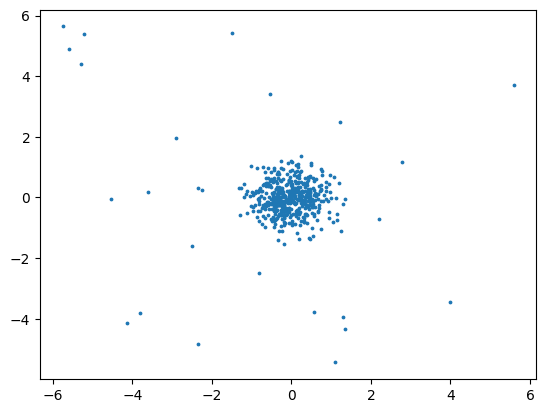

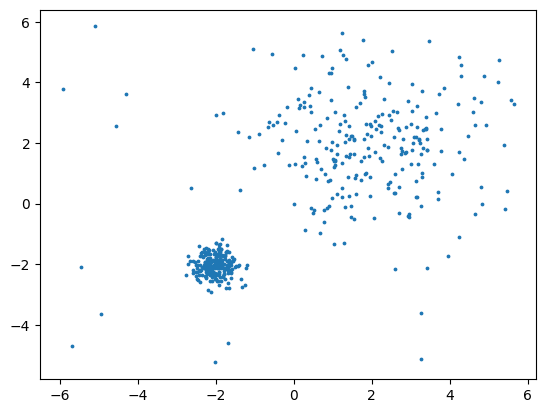

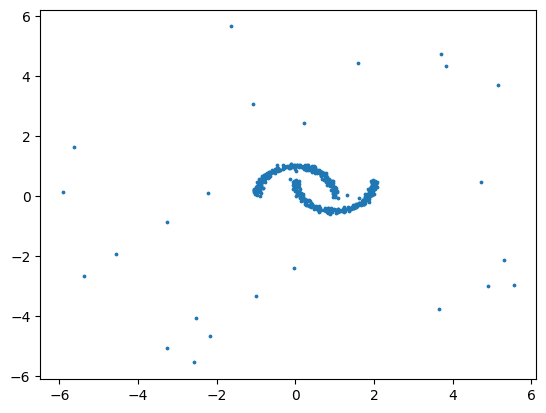

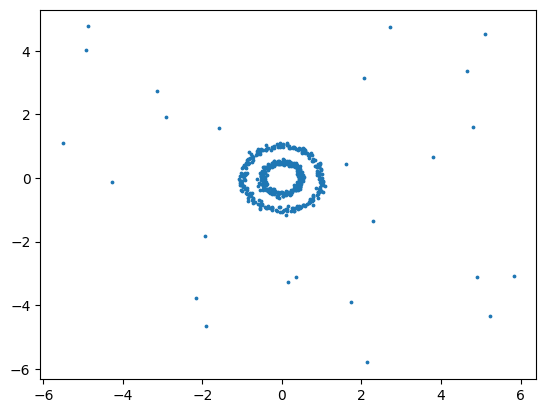

In [3]:
for data in [data_blobs_1, data_blobs_2, data_moons, data_circles]:
    plt.figure()
    plt.scatter(data[:,0], data[:,1], s=3)

### 1.1 Helper function

As usual we define a helper function to plot the results of the outlier detection.

In [4]:
# Helper function to plot one classifier

def plot(X, y, clf_contour=None, y_true=None, title=None):
    colors = np.array(["#377eb8", "#ff7f00"])

    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], s=3, color=colors[(y + 1) // 2])

    if clf_contour is not None:
        xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))
        Z = clf_contour.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")

    accuracy = ""
    if y_true is not None:
        accuracy = f" Accuracy {(y == y_true).astype(int).sum().item() / y_true.size * 100:.2f}"

    if title is not None:
        plt.title(title + " " + accuracy)
    else:
        plt.title(accuracy)

## 2. One-class SVM

SVM is a classfication method to find a maximum-margin hyperplane which separates two classes. Since data might not be easily spearable in the ioriginal space, SVM uses kernel function to map the data into different spaces (and uses the kernel trick to reduce the computational burden).
![kenrel.png](https://upload.wikimedia.org/wikipedia/commons/f/fe/Kernel_Machine.svg)

Figure <a href="//commons.wikimedia.org/wiki/File:Kernel_Machine.png" title="File:Kernel Machine.png">source</a>.

It is possible to adapt SVM to isolate one class using the origin trick: points are separated from the origin by a hyperplane which has the maximum distance from the origin.


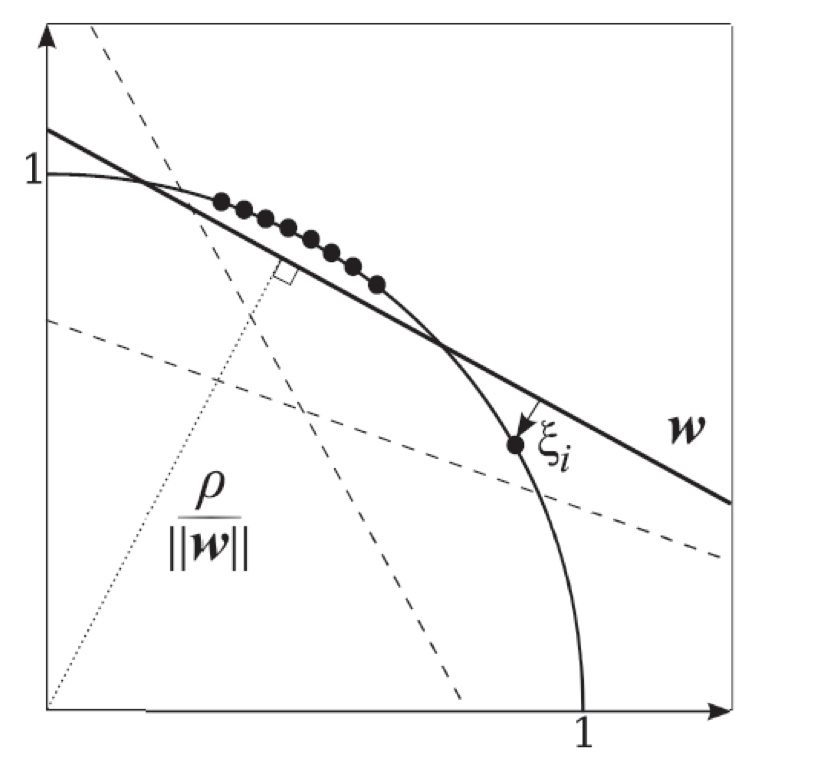


All *normal* points are One-class SVM allows to fit a model on *normal* data with a farction of points being allowed to be on the other side. The fraction is controlled by the hyper parameter `nu`.

### 2.1 Fitting a One-class SVM

Let's try to fit a one-class SVM model on `data_blobs_1` using `rbf` (radial basis function) and default parameter values.

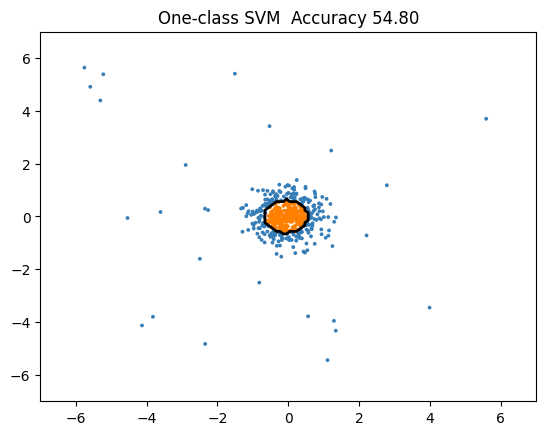

In [6]:
from sklearn.svm import OneClassSVM

clf = OneClassSVM(kernel="rbf")

y_pred = clf.fit_predict(data_blobs_1)

plot(data_blobs_1, y_pred, clf_contour=clf, y_true=data_labels, title="One-class SVM")

We got a nice contour in the middle but many *visually* normal points are still outside. Indeed the accuracy is rather low. Can we improve it?

### 2.2 Tuning the parameters

The main parameter of one-class SVM is `nu`, the fraction of outliers, with default value of `0.5`. Another parameter is `gamma` which influences the shape of `rbf` kernel function ($\gamma = \frac{1}{\sigma^2}$).

One easy way to tune hyperparameters is to a search across a grid of combinations. This can be done via [ParameterGrid](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html#sklearn.model_selection.ParameterGrid). We need to define the list of values for each parameter and ParameterGrid wil try all possible combinations.

In [7]:
from sklearn.model_selection import ParameterGrid

param_grid = [
    {"nu": np.linspace(0.01, 0.5, 50).tolist(),
     "gamma": [0.1, 0.01]
    }
]

clf = OneClassSVM(kernel="rbf")

tuning = []

for z in ParameterGrid(param_grid):
    clf.set_params(**z)
    clf.fit(data_blobs_1)
    y_pred = clf.fit_predict(data_blobs_1)
    accuracy = (y_pred == data_labels).astype(int).sum().item() / data_labels.size * 100
    tuning.append((accuracy, z))
    print(f"Accuracy {accuracy:.2f} using: {z}")


Accuracy 95.40 using: {'gamma': 0.1, 'nu': 0.01}
Accuracy 96.60 using: {'gamma': 0.1, 'nu': 0.02}
Accuracy 98.00 using: {'gamma': 0.1, 'nu': 0.03}
Accuracy 97.80 using: {'gamma': 0.1, 'nu': 0.04}
Accuracy 98.60 using: {'gamma': 0.1, 'nu': 0.05}
Accuracy 99.00 using: {'gamma': 0.1, 'nu': 0.060000000000000005}
Accuracy 97.80 using: {'gamma': 0.1, 'nu': 0.06999999999999999}
Accuracy 97.20 using: {'gamma': 0.1, 'nu': 0.08}
Accuracy 96.00 using: {'gamma': 0.1, 'nu': 0.09}
Accuracy 95.20 using: {'gamma': 0.1, 'nu': 0.09999999999999999}
Accuracy 94.00 using: {'gamma': 0.1, 'nu': 0.11}
Accuracy 92.80 using: {'gamma': 0.1, 'nu': 0.12}
Accuracy 91.80 using: {'gamma': 0.1, 'nu': 0.13}
Accuracy 91.20 using: {'gamma': 0.1, 'nu': 0.14}
Accuracy 89.80 using: {'gamma': 0.1, 'nu': 0.15000000000000002}
Accuracy 88.80 using: {'gamma': 0.1, 'nu': 0.16}
Accuracy 88.00 using: {'gamma': 0.1, 'nu': 0.17}
Accuracy 87.20 using: {'gamma': 0.1, 'nu': 0.18000000000000002}
Accuracy 86.00 using: {'gamma': 0.1, 'nu':

In [11]:
tuning #just a dictionary

[(95.39999999999999, {'gamma': 0.1, 'nu': 0.01}),
 (96.6, {'gamma': 0.1, 'nu': 0.02}),
 (98.0, {'gamma': 0.1, 'nu': 0.03}),
 (97.8, {'gamma': 0.1, 'nu': 0.04}),
 (98.6, {'gamma': 0.1, 'nu': 0.05}),
 (99.0, {'gamma': 0.1, 'nu': 0.060000000000000005}),
 (97.8, {'gamma': 0.1, 'nu': 0.06999999999999999}),
 (97.2, {'gamma': 0.1, 'nu': 0.08}),
 (96.0, {'gamma': 0.1, 'nu': 0.09}),
 (95.19999999999999, {'gamma': 0.1, 'nu': 0.09999999999999999}),
 (94.0, {'gamma': 0.1, 'nu': 0.11}),
 (92.80000000000001, {'gamma': 0.1, 'nu': 0.12}),
 (91.8, {'gamma': 0.1, 'nu': 0.13}),
 (91.2, {'gamma': 0.1, 'nu': 0.14}),
 (89.8, {'gamma': 0.1, 'nu': 0.15000000000000002}),
 (88.8, {'gamma': 0.1, 'nu': 0.16}),
 (88.0, {'gamma': 0.1, 'nu': 0.17}),
 (87.2, {'gamma': 0.1, 'nu': 0.18000000000000002}),
 (86.0, {'gamma': 0.1, 'nu': 0.19}),
 (85.0, {'gamma': 0.1, 'nu': 0.2}),
 (84.2, {'gamma': 0.1, 'nu': 0.21000000000000002}),
 (83.0, {'gamma': 0.1, 'nu': 0.22}),
 (82.0, {'gamma': 0.1, 'nu': 0.23}),
 (81.0, {'gamma': 0.

In [8]:
import pandas as pd

# Print top 10 parameter configurations
pd.DataFrame(tuning, columns=["Accuracy", "Parameters"]).sort_values(by="Accuracy", ascending=False).head(10)

,Accuracy,Parameters
53,99.0,"{'gamma': 0.01, 'nu': 0.04}"
5,99.0,"{'gamma': 0.1, 'nu': 0.060000000000000005}"
54,98.8,"{'gamma': 0.01, 'nu': 0.05}"
4,98.6,"{'gamma': 0.1, 'nu': 0.05}"
55,98.2,"{'gamma': 0.01, 'nu': 0.060000000000000005}"
2,98.0,"{'gamma': 0.1, 'nu': 0.03}"
52,98.0,"{'gamma': 0.01, 'nu': 0.03}"
56,98.0,"{'gamma': 0.01, 'nu': 0.06999999999999999}"
3,97.8,"{'gamma': 0.1, 'nu': 0.04}"
6,97.8,"{'gamma': 0.1, 'nu': 0.06999999999999999}"


Plot with best parameter found during the sweep.

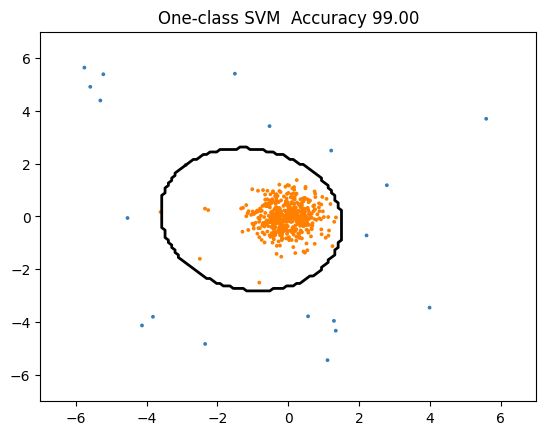

In [9]:
from sklearn.svm import OneClassSVM

clf = OneClassSVM(kernel="rbf")
z_best = pd.DataFrame(tuning, columns=["Accuracy", "Parameters"]).sort_values(by="Accuracy", ascending=False).head(1)["Parameters"].values[0]

clf.set_params(**z_best)

y_pred = clf.fit_predict(data_blobs_1)

plot(data_blobs_1, y_pred, clf_contour=clf, y_true=data_labels, title="One-class SVM")

Based on the above let's define a helper fucntion for tuning.

In [10]:
def tune(clf, param_grid, data, verbose=False):

    tuning = []

    for z in ParameterGrid(param_grid):
        clf.set_params(**z)
        clf.fit(data)
        y_pred = clf.fit_predict(data)
        accuracy = (y_pred == data_labels).astype(int).sum().item() / data_labels.size * 100
        tuning.append((accuracy, z))
        if verbose:
            print(f"Accuracy {accuracy:.2f} using: {z}")

    df = pd.DataFrame(tuning, columns=["Accuracy", "Parameters"]).sort_values(by="Accuracy", ascending=False)
    z_best = df.head(1)["Parameters"].values[0]

    return z_best, df


## 2.3 Exercise

Repeat the experiment with the other datasets.

In [ ]:
# Repeat on data_blobs_2, data_moons, data_circles

## 3. EllipticEnvelope


[EllipticEnvelope](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope) assumes that the regular data comes from a known distribution (e.g. Gaussian).After fitting the distribution it uses the Mahalanobis distance to score outliers.

The main parameter is `contamination`, i.e. the fraction of outliers.

In [ ]:
from sklearn.covariance import EllipticEnvelope

clf = EllipticEnvelope(random_state=42)

param_grid = [
    {"contamination": np.linspace(0.01, 0.5, 50).tolist()
    }
]

z_best, df = tune(clf, param_grid, data_blobs_1, verbose=True)

clf.set_params(**z_best)
y_pred = clf.fit_predict(data_blobs_1)

plot(data_blobs_1, y_pred, clf_contour=clf, y_true=data_labels, title="Elliptic Envelope")

### 3.1 Exercise

Apply the EllipticEnvelope to the other datasets. Check what is the best parameter for each one.

In [ ]:
# Repeat on data_blobs_2, data_moons, data_circles

## 4. Isolation Forrest

[IsolationForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest)uses the idea of random forrests, i.e., ensembles of decision trees, to score outliers. The number of splittings in a decision tree needed to isolate a sample can be used to score outliers. Averaged over the forrest anomlous data has noticeably fewer splits.

The main parameter is `contamination`, i.e. the fraction of outliers. Another parameter is the number of tress to use, i.e. `n_estimators`.


In [ ]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(random_state=42)

param_grid = [
    {"contamination": np.linspace(0.01, 0.5, 50).tolist(), "n_estimators" : [10, 50, 100]
    }
]

z_best, df = tune(clf, param_grid, data_blobs_1, verbose=True)

clf.set_params(**z_best)
y_pred = clf.fit_predict(data_blobs_1)

plot(data_blobs_1, y_pred, clf_contour=clf, y_true=data_labels, title="Isolation Forrest")

### 4.1 Exercise

Apply the IsolationForest to the other datasets. Check what is the best parameter for each one.

In [ ]:
# Repeat on data_blobs_2, data_moons, data_circles

### 5. Local Outlier Factor

[LocalOutlierFactor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor) measures the devaition of the local deviation of the density of a given sample with respect to its neighbors.

Main parameters are the number of neighbors `n_neighbors` and the `contamination` used to calibrate the radius.

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor()

param_grid = [
    {"contamination": np.linspace(0.01, 0.5, 50).tolist(), "n_neighbors" : [10, 20, 30, 40, 50]
    }
]

z_best, df = tune(clf, param_grid, data_blobs_1, verbose=True)

clf.set_params(**z_best)
y_pred = clf.fit_predict(data_blobs_1)

plot(data_blobs_1, y_pred, y_true=data_labels, title="Local Outlier Factor")

### 5.1 Exercise

Apply the LocalOutlierFactor to the other datasets. Check what is the best parameter for each one.

In [ ]:
# Repeat on data_blobs_2, data_moons, data_circles